In [40]:
import os
import datetime as dt

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

import coropy.reproduction_rate as R
from coropy.compartmental_models import SEIRDModel
import plotting

In [16]:
# all data
DATA_DIR = 'data'
FILE_NAMES = ['initial_timeseries_SEIRD.csv',
              '2nd_wave_timeseries_SEIRD.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

# we have to observe 15 values from the second wave in order to acquire R0 for the full first wave
eff_diff = 15
first_wave_len = len(df_1)
eff_confirmed_cases = cum_positives[:first_wave_len + eff_diff]

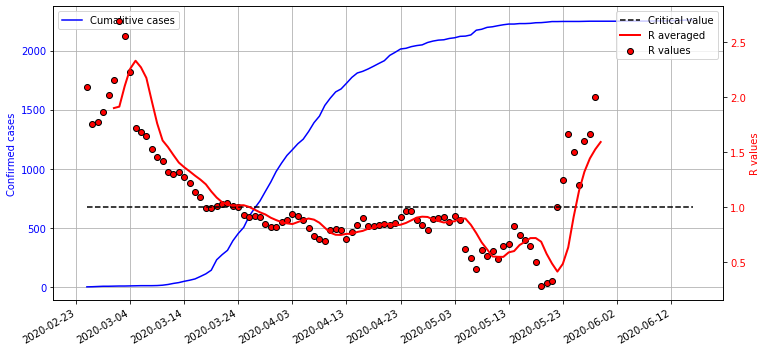

In [21]:
R.simulate(
    epidemics_start_date=dt.datetime(2020, 2, 25),
    confirmed_cases=eff_confirmed_cases,
    averaging_period=16,
    symptoms_delay=3,
)

In [61]:
R_estim = R._estimate(eff_confirmed_cases[:30], 14, 3)
R0_exp = np.mean(R_estim)
R0_ci = np.std(R_estim)
print(f'R0 = {round(R0_exp, 4)} +/- {round(R0_ci, 4)}')

R0 = 2.0838 +/- 0.304


In [62]:
# initial conditions
S0 = cum_positives[first_wave_len-1] + cum_deceased[first_wave_len-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
IC = [S0, E0, I0, R0, D0]

model = SEIRDModel()
params, loss = model.fit(
    cum_positives[:first_wave_len],
    cum_recovered[:first_wave_len],
    cum_deceased[:first_wave_len],
    IC, guess=[0.1, 0.1, 0.1, 0.1])

R0 = params[0]/(params[2]+params[1])
print(f'<R0> = {round(R0, 4)}')

INFO:root:L-BFGS-B optimization started: 2020-10-13 16:58:28.375128
INFO:root:Elapsed time: 3.3366s
<R0> = 1.8048
